In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aloksp1","key":"8efb032fe173ce3787d1690b9fc3c699"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 40.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.7MB/s]


In [5]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics import roc_auc_score

# for show images
import cv2
import random
random.seed(1)

In [7]:
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

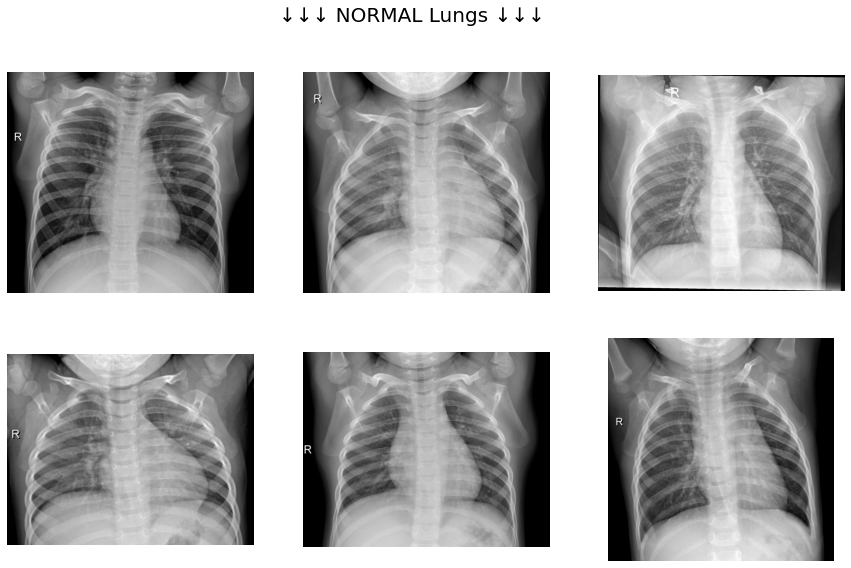

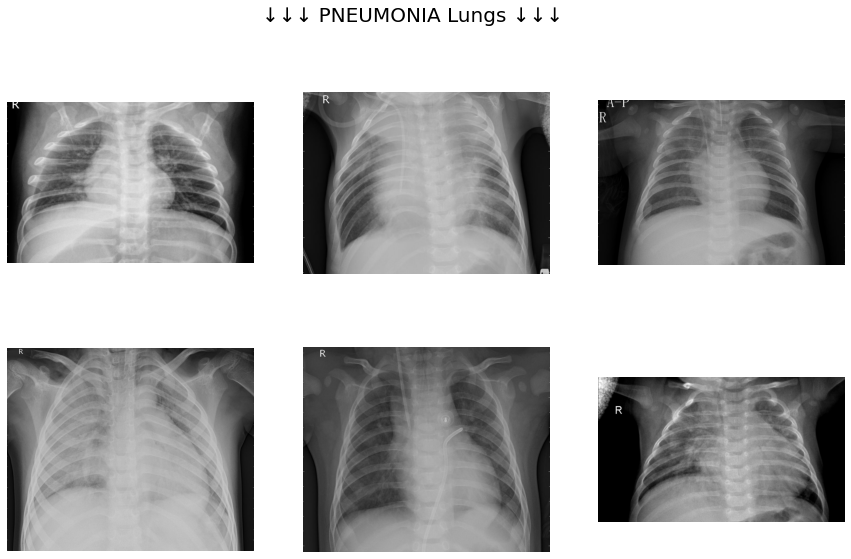

In [8]:
classes = ['NORMAL', 'PNEUMONIA']

for c in classes:
    target_path = os.path.join(train_dir, c)
    sample_normal = random.sample(os.listdir(os.path.join(train_dir, c)),6)
    f,ax = plt.subplots(2,3,figsize=(15,9))

    for i in range(6):
        im = cv2.imread(os.path.join(target_path, sample_normal[i]))
        ax[i//3,i%3].imshow(im)
        ax[i//3,i%3].axis('off')
    f.suptitle("↓↓↓ {} Lungs ↓↓↓".format(c), fontsize=20)
    plt.show()

# The necessity of pre-processing in pytorch

---
# data transform


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(), # randomly flip and rotate
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

# Data set and dataloader

In [10]:
batch_size = 32

data_sets = {
    'train': torchvision.datasets.ImageFolder(train_dir,data_transforms['train']),
    'test': torchvision.datasets.ImageFolder(test_dir,data_transforms['test']),
    'val': torchvision.datasets.ImageFolder(val_dir,data_transforms['val']),
}

data_loaders = {
    'train': DataLoader(data_sets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(data_sets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(data_sets['test'], batch_size=batch_size, shuffle=True, num_workers=4)
}

In [11]:

dir_ = [train_dir, val_dir, test_dir]
x = []
y = []

for i in range(3):
    target_normal = os.listdir(os.path.join(dir_[i], 'NORMAL'))
    target_pneumonia = os.listdir(os.path.join(dir_[i], 'PNEUMONIA'))
    x.append(len(target_normal))
    y.append(len(target_pneumonia))
    
    print("In {} folder... \n normal:{} \t pneumonia: {}".format(os.path.basename(dir_[i]), x[i], y[i]))

In train folder... 
 normal:1341 	 pneumonia: 3875
In val folder... 
 normal:8 	 pneumonia: 8
In test folder... 
 normal:234 	 pneumonia: 390


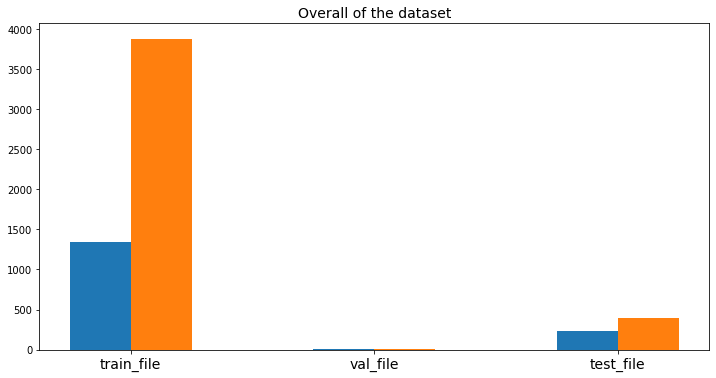

In [12]:
labels = ['train_file', 'val_file', 'test_file']
plt.figure(figsize=(12, 6))
width = 0.25
plt.bar(np.arange(len(x))- width/2, x, width, label="normal")
plt.bar(np.arange(len(x))+ width/2, y, width, label="pneumonia")
plt.xticks(np.arange(len(x)), labels, fontsize=14)

plt.title("Overall of the dataset", fontsize=14)
plt.show()

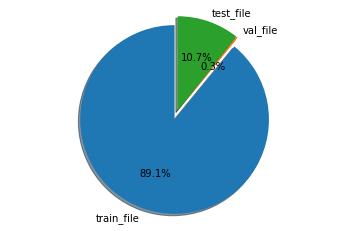

In [13]:
size_dataset = sum(x) + sum(y)
sizes = []
for i in range(3):
    sizes.append(100 * (x[i]+y[i])/size_dataset)
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

# Input the densenet121 model

In [14]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [15]:
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1024,256)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(32,2)),
    ('out', nn.LogSoftmax(dim=1)),
]))

In [16]:
history = []
def train_function(model, train_loader, valid_loader, criterion, optimizer, scheduler=None,
                       train_on_gpu=False, n_epochs=30, save_file='model.pth'):
    
    valid_loss_min = 0.218098#np.Inf
    if train_on_gpu:
        model.cuda()
    for epoch in range(1, n_epochs + 1):
        # stop training the feature CNN after epochs/2 epochs    
        if epoch == n_epochs // 2:
            model.load_state_dict(torch.load(save_file))
            for param in model.features.parameters():
                param.requires_grad = False
            
        train_loss = 0.0
        valid_loss = 0.0
        if scheduler != None:
            scheduler.step()
        model.train()
        number_tcorrect, number_tdata = 0, 0
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()   
            train_loss += loss.item() * data.size(0)
             ############# calculate the train accurecy
            _, pred = torch.max(output, 1) 
            correct_tensor1 = pred.eq(target.data.view_as(pred))
            correct1 = np.squeeze(correct_tensor1.numpy()) if not train_on_gpu \
                                    else np.squeeze(correct_tensor1.cpu().numpy())
            number_tcorrect += sum(correct1)
            number_tdata += correct1.shape[0]

        ######################    
        # validate the model #
        ######################
        model.eval()
        number_vcorrect, number_vdata = 0, 0
        for data, target in valid_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            ############# calculate the validation accurecy
            _, pred = torch.max(output, 1) 
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu \
                                    else np.squeeze(correct_tensor.cpu().numpy())
            number_vcorrect += sum(correct)
            number_vdata += correct.shape[0]
            ###################################
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        train_accuracy = (100 * number_tcorrect / number_tdata)
        valid_accuracy = (100 * number_vcorrect / number_vdata)
        print('Epoch: {} \n-----------------\n \tTraining Loss: {:.6f} \t Validation Loss: {:.6f} \t train accuracy : {:.4f}% \t validation accuracy : {:.4f}% '.format(epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_file)
            valid_loss_min = valid_loss
        history.append({'train_loss': train_loss, 'val_loss': valid_loss, 'train_acc' : train_accuracy,'val_acc':valid_accuracy})
    model.to('cpu')
    return torch.load(save_file)

In [17]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('GPU is  available :)   Training on GPU ...')
else:
    print('GPU is not available :(  Training on CPU ...') 

GPU is  available :)   Training on GPU ...


In [18]:
criterion = nn.NLLLoss()
optimizer = optim.Adadelta(model.parameters())

model_state_dict = train_function(
                            model,
                            data_loaders['train'],
                            data_loaders['val'],
                            criterion=criterion,
                            optimizer=optimizer,
                            scheduler=None,
                            train_on_gpu=train_on_gpu,
                            n_epochs=40,
                            save_file='saved_state.pth'
                            )

model.load_state_dict(model_state_dict)

Epoch: 1 
-----------------
 	Training Loss: 0.205477 	 Validation Loss: 0.960626 	 train accuracy : 92.2929% 	 validation accuracy : 68.7500% 
Epoch: 2 
-----------------
 	Training Loss: 0.103591 	 Validation Loss: 0.975550 	 train accuracy : 96.4916% 	 validation accuracy : 68.7500% 
Epoch: 3 
-----------------
 	Training Loss: 0.085161 	 Validation Loss: 0.519100 	 train accuracy : 97.0475% 	 validation accuracy : 68.7500% 
Epoch: 4 
-----------------
 	Training Loss: 0.070677 	 Validation Loss: 0.367853 	 train accuracy : 97.5077% 	 validation accuracy : 81.2500% 
Epoch: 5 
-----------------
 	Training Loss: 0.074477 	 Validation Loss: 1.248656 	 train accuracy : 97.4885% 	 validation accuracy : 68.7500% 
Epoch: 6 
-----------------
 	Training Loss: 0.066164 	 Validation Loss: 2.626670 	 train accuracy : 97.7186% 	 validation accuracy : 62.5000% 
Epoch: 7 
-----------------
 	Training Loss: 0.071858 	 Validation Loss: 0.990440 	 train accuracy : 97.6994% 	 validation accuracy : 56

<All keys matched successfully>

Text(0.5, 1.0, 'Training and Validation Losses')

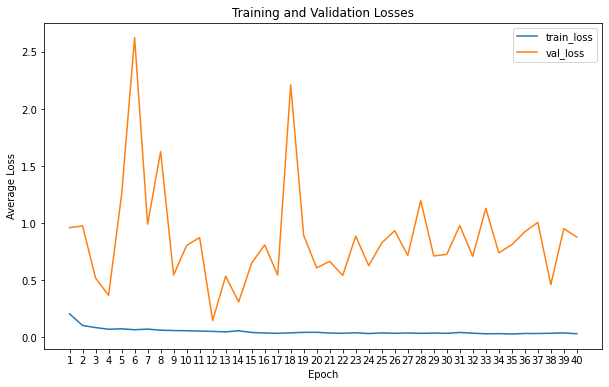

In [27]:
df = pd.DataFrame(history)
df.head()

plt.figure(figsize=(10, 6))
for c in ['train_loss', 'val_loss']:
    plt.plot(
        df[c], label=c)
plt.legend()
plt.xlabel('Epoch')
X=range(0,40, )
xt=range(1,41,)
plt.xticks(X, xt)


plt.ylabel('Average Loss')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

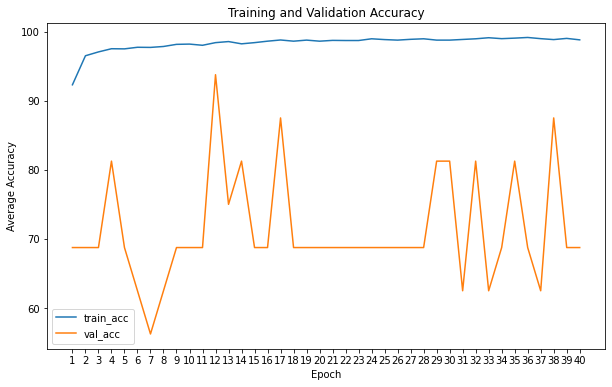

In [28]:

plt.figure(figsize=(10, 6))
for c in ['train_acc', 'val_acc']:
    plt.plot(
        df[c], label=c)
plt.legend()
plt.xlabel('Epoch')
X=range(0,40, )
xt=range(1,41,)
plt.xticks(X, xt)

plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [29]:
def test(model, train_loader, train_on_gpu, criterion, classes):
    print('--- Test starts on train dataset  x-ray images  ---')
    test_loss = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    
    if train_on_gpu:
        model.cuda()
        
    test_start = timer()
    model.eval()
    cat_accuracy = {}
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        
        _, pred = torch.max(output, 1) 
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu \
                                else np.squeeze(correct_tensor.cpu().numpy())
        
        print(f'{timer() - test_start:.2f} seconds elapsed in test mode.',
            end='\r')
        
        for i in range(data.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    test_loss = test_loss / len(train_loader.dataset)
    print("Train Loss: {:.6f}".format(test_loss))
   
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Train Accuracy of %s : %d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Train Accuracy of %s: N/A (no training examples)' % (classes[str(i+1)]))
    print("\n ----------------------\nTrain Accuracy (Overall): %2d%% (%2d/%2d)" % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

In [22]:
criterion = nn.NLLLoss()
test(model, data_loaders['train'], train_on_gpu, criterion, classes)

--- Test starts on train dataset  x-ray images  ---
Train Loss: 0.079906
Train Accuracy of NORMAL : 99% (1336/1341)
Train Accuracy of PNEUMONIA : 96% (3739/3875)

 ----------------------
Train Accuracy (Overall): 97% (5075/5216)


In [32]:
def test(model, val_loader, train_on_gpu, criterion, classes):
    print('--- Test starts on Validation dataset  x-ray images  ---')
    test_loss = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    
    if train_on_gpu:
        model.cuda()
        
    test_start = timer()
    model.eval()
    cat_accuracy = {}
    for data, target in val_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        
        _, pred = torch.max(output, 1) 
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu \
                                else np.squeeze(correct_tensor.cpu().numpy())
        
        print(f'{timer() - test_start:.2f} seconds elapsed in test mode.',
            end='\r')
        
        for i in range(data.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    test_loss = test_loss / len(val_loader.dataset)
    print("Validation Loss: {:.6f}".format(test_loss))
   
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Validation Accuracy of %s : %d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Validation Accuracy of %s: N/A (no training examples)' % (classes[str(i+1)]))
    print("\n ----------------------\nValidation Accuracy (Overall): %2d%% (%2d/%2d)" % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

In [24]:
criterion = nn.NLLLoss()
test(model, data_loaders['val'], train_on_gpu, criterion, classes)

--- Test starts on Validation dataset  x-ray images  ---
Validation Loss: 0.147246
Validation Accuracy of NORMAL : 87% ( 7/ 8)
Validation Accuracy of PNEUMONIA : 100% ( 8/ 8)

 ----------------------
Validation Accuracy (Overall): 93% (15/16)


In [33]:
def test(model, test_loader, train_on_gpu, criterion, classes):
    print('--- Test starts on test dataset  x-ray images  ---')
    test_loss = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    
    if train_on_gpu:
        model.cuda()
        
    test_start = timer()
    model.eval()
    cat_accuracy = {}
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        
        _, pred = torch.max(output, 1) 
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu \
                                else np.squeeze(correct_tensor.cpu().numpy())
        
        print(f'{timer() - test_start:.2f} seconds elapsed in test mode.',
            end='\r')
        
        for i in range(data.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    test_loss = test_loss / len(test_loader.dataset)
    print("Test Loss: {:.6f}".format(test_loss))
   
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %s : %d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %s: N/A (no training examples)' % (classes[str(i+1)]))
    print("\n ----------------------\nTest Accuracy (Overall): %2d%% (%2d/%2d)" % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

In [31]:
criterion = nn.NLLLoss()
test(model, data_loaders['test'], train_on_gpu, criterion, classes)

--- Test starts on test dataset  x-ray images  ---
Test Loss: 0.337909
Test Accuracy of NORMAL : 86% (203/234)
Test Accuracy of PNEUMONIA : 96% (375/390)

 ----------------------
Test Accuracy (Overall): 92% (578/624)
